<a href="https://colab.research.google.com/github/vikasg964/Network/blob/main/Network_intrusion_detector1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports


In [ ]:
%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
training_df = pd.read_csv('/content/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('/content/UNSW_NB15_testing-set.csv')

In [ ]:
print(training_df.shape)
test_df.shape

(82332, 45)


(131020, 45)

In [ ]:
training_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
#counting no of rows in training data to check if the file was imported properly
file = open("/content/UNSW_NB15_training-set.csv")
numline = len(file.readlines())
print (numline)

82333


In [ ]:
test_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0.0,0.0,0.0,1.0,1.0,0.0,Normal,0.0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0.0,0.0,0.0,1.0,6.0,0.0,Normal,0.0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0.0,0.0,0.0,2.0,6.0,0.0,Normal,0.0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1.0,1.0,0.0,2.0,1.0,0.0,Normal,0.0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0.0,0.0,0.0,2.0,39.0,0.0,Normal,0.0


In [ ]:
training_df=pd.read_csv('/content/UNSW_NB15_training-set.csv', na_values=['-','?'])
training_df[training_df.isnull().any(axis=1)]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,NaN,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,NaN,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,NaN,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,NaN,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,NaN,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,NaN,INT,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,NaN,FIN,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.7,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,NaN,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,NaN,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.0,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0


In [ ]:
training_df=training_df.dropna()

In [ ]:
training_df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,36,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,62,252,5976.375000,8342.531250,2,2,109.319333,124.932859,5929.211713,192.590406,255,794167371,1624757001,255,0.206572,0.108393,0.098179,82,147,1,184,2,1,1,1,1,2,0,0,1,1,3,0,Normal,0
40,41,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,62,252,3876.882812,5940.385254,2,2,170.481889,159.070562,11933.065600,244.118016,255,708428911,3141441573,255,0.180318,0.103612,0.076706,83,127,1,187,2,1,1,1,1,2,0,0,1,1,3,0,Normal,0
45,46,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,62,252,5641.147461,7498.874512,2,2,117.706556,132.899281,6102.668305,255.756219,255,1853677305,1202418679,255,0.274887,0.128459,0.146428,83,142,1,165,1,1,1,1,1,1,0,0,1,3,1,0,Normal,0
49,50,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,62,252,5847.268066,10281.177730,2,2,110.060889,100.616555,7172.956819,143.497953,255,1528762476,1066585482,255,0.181441,0.084249,0.097192,80,141,1,261,2,1,18,1,1,2,0,0,1,1,2,0,Normal,0
72,73,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,62,252,5057.083984,6014.492676,2,2,118.501635,175.467000,6491.561713,252.408328,255,1182907296,802589817,255,0.140062,0.074510,0.065552,75,140,1,157,1,1,1,1,1,1,0,0,1,2,1,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81462,81463,0.818276,tcp,http,FIN,60,14,68199,612,89.211954,254,252,655651.625000,5562.915039,27,1,13.441272,56.755152,1376.971154,76.224305,255,3137145926,3197614932,255,0.154745,0.080450,0.074295,1137,44,1,0,1,1,1,1,1,2,0,0,1,1,1,0,Normal,0
81466,81467,0.825170,tcp,http,FIN,60,14,68199,612,88.466621,254,252,650173.937500,5516.438965,27,1,13.969984,57.166383,1389.032442,82.519703,255,3567303131,4168480199,255,0.113208,0.081998,0.031210,1137,44,1,0,1,1,45,1,1,1,0,0,1,1,1,0,Normal,0
81518,81519,0.874942,tcp,http,FIN,60,14,68199,612,83.434101,254,252,613188.062500,5202.630371,27,1,14.591627,63.407922,1526.290325,97.276484,255,1516200001,1237225352,255,0.104980,0.050635,0.054345,1137,44,1,0,2,1,23,1,1,2,0,0,1,1,2,0,Normal,0
81540,81541,0.740231,tcp,http,FIN,60,14,68199,612,98.617867,254,252,724779.187500,6149.432129,27,1,12.379305,53.710461,1300.964841,83.333812,255,860363568,341738851,255,0.082721,0.041986,0.040735,1137,44,1,0,3,1,25,1,1,3,0,0,1,1,3,0,Normal,0


In [ ]:
test_df=pd.read_csv('/content/UNSW_NB15_testing-set.csv', na_values=['-','?']) 
test_df[test_df.isnull().any(axis=1)]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,NaN,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,NaN,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,NaN,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
4,5,0.449454,tcp,NaN,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
5,6,0.380537,tcp,NaN,FIN,10,6,534,268,39.417980,254,252,10112.025390,4709.134766,2,1,39.928778,52.241000,2223.730342,82.550500,255,3984155503,1796040391,255,0.172934,0.119331,0.053603,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175125,175126,0.653375,tcp,NaN,FIN,10,8,564,354,26.018748,254,252,6220.011230,3795.676025,2,1,70.986667,89.141570,5392.277592,133.977047,255,2253863811,2106263381,255,0.052156,0.029376,0.022780,56,44,0,0,1,1,1,1,1,1,0,0,0,18,1,0,Reconnaissance,1
175179,175180,0.695566,tcp,NaN,FIN,10,8,564,354,24.440528,254,252,5842.723633,3565.441650,2,1,76.977778,90.474711,5483.590978,137.802578,255,1007444130,2612789708,255,0.098478,0.062234,0.036244,56,44,0,0,1,1,1,1,1,1,0,0,0,3,1,0,Reconnaissance,1
175191,175192,0.962856,tcp,NaN,FIN,24,60,1256,59374,86.201883,62,252,10003.573240,485098.500000,6,28,41.863305,16.133339,2031.193057,1279.137355,255,653911003,215395963,255,0.046912,0.010253,0.036659,52,990,0,0,1,1,1,1,1,1,0,0,0,1,1,0,Exploits,1
175277,175278,3.719110,tcp,NaN,FIN,66,340,3086,426483,108.897021,62,252,6539.198730,914689.812500,6,167,57.217077,10.914012,3358.369752,1585.622696,255,3046870123,1723342386,255,0.060793,0.025596,0.035197,47,1254,0,0,1,1,1,1,1,1,0,0,0,2,1,0,Exploits,1


In [ ]:
test_df=test_df.dropna()
test_df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
11,12,2.093085,tcp,smtp,FIN,62,28,56329,2212,42.520967,62,252,2.118251e+05,8152.559082,28,8,34.312868,75.092445,3253.278833,106.113453,255,1824722662,860716719,255,0.131140,0.052852,0.078288,909,79,0,0,2,1,1,1,1,2,0,0,0,1,1,0,Normal,0
15,16,0.000002,udp,snmp,INT,2,0,138,0,500000.001300,254,0,2.760000e+08,0.000000,0,0,0.002000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,69,0,0,0,1,2,1,1,1,4,0,0,0,2,1,0,Normal,0
17,18,0.393556,tcp,http,FIN,10,8,860,1096,43.195886,62,252,1.573347e+04,19494.048830,2,2,43.728444,47.669145,2124.837873,71.805867,255,3882971404,3084071099,255,0.120313,0.059201,0.061112,86,137,1,103,3,1,1,1,1,2,0,0,1,1,3,0,Normal,0
21,22,0.338017,tcp,http,FIN,10,6,998,268,44.376468,254,252,2.127704e+04,5301.508789,2,1,35.218111,56.579801,1928.550710,82.022258,255,2665974075,3521361798,255,0.154433,0.055109,0.099324,100,45,1,0,6,1,1,1,1,1,0,0,1,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175335,175336,0.000006,udp,dns,INT,2,0,114,0,166666.660800,254,0,7.600000e+07,0.000000,0,0,0.006000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,45,2,33,33,17,45,0,0,0,33,45,0,Generic,1
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [ ]:
print(training_df.head())
print(test_df.head())

print("\nNumber of col/row originally:")
print("Train data: ", training_df.shape)
print("Test data: ",test_df.shape)

    id       dur proto service  ... ct_srv_dst  is_sm_ips_ports  attack_cat  label
35  36  0.983874   tcp    http  ...          3                0      Normal      0
40  41  1.535254   tcp    http  ...          3                0      Normal      0
45  46  1.059359   tcp    http  ...          1                0      Normal      0
49  50  0.990548   tcp    http  ...          2                0      Normal      0
72  73  1.303518   tcp    http  ...          1                0      Normal      0

[5 rows x 45 columns]
    id       dur proto service  ... ct_srv_dst  is_sm_ips_ports  attack_cat  label
3    4  1.681642   tcp     ftp  ...          1                0      Normal      0
11  12  2.093085   tcp    smtp  ...          1                0      Normal      0
15  16  0.000002   udp    snmp  ...          1                0      Normal      0
17  18  0.393556   tcp    http  ...          3                0      Normal      0
21  22  0.338017   tcp    http  ...          3                0 

combine train and test data


In [ ]:
frames = [training_df, test_df]
df = pd.concat(frames)

In [ ]:
print(df.shape)
df.head()


(116352, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,36,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,62,252,5976.375000,8342.531250,2,2,109.319333,124.932859,5929.211713,192.590406,255,794167371,1624757001,255,0.206572,0.108393,0.098179,82,147,1,184,2,1,1,1,1,2,0,0,1,1,3,0,Normal,0
40,41,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,62,252,3876.882812,5940.385254,2,2,170.481889,159.070562,11933.065600,244.118016,255,708428911,3141441573,255,0.180318,0.103612,0.076706,83,127,1,187,2,1,1,1,1,2,0,0,1,1,3,0,Normal,0
45,46,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,62,252,5641.147461,7498.874512,2,2,117.706556,132.899281,6102.668305,255.756219,255,1853677305,1202418679,255,0.274887,0.128459,0.146428,83,142,1,165,1,1,1,1,1,1,0,0,1,3,1,0,Normal,0
49,50,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,62,252,5847.268066,10281.177730,2,2,110.060889,100.616555,7172.956819,143.497953,255,1528762476,1066585482,255,0.181441,0.084249,0.097192,80,141,1,261,2,1,18,1,1,2,0,0,1,1,2,0,Normal,0
72,73,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,62,252,5057.083984,6014.492676,2,2,118.501635,175.467000,6491.561713,252.408328,255,1182907296,802589817,255,0.140062,0.074510,0.065552,75,140,1,157,1,1,1,1,1,1,0,0,1,2,1,0,Normal,0


In [ ]:
# Drop the missing values
df = df.dropna()

# Drop the id column
df.drop('id', axis=1, inplace=True)

# Drop the attack_cat column. Not needed, it does not affect the data
df.drop('attack_cat', axis=1, inplace=True)

# Drop the is_sm_ips_ports column. Not significant
df.drop('is_sm_ips_ports', axis=1, inplace=True)

# Remove any existing duplicates rows to avoid biased decisions
df.drop_duplicates(keep='first', inplace=True)

In [ ]:
print(df.shape)
df.head()

(61221, 42)


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label
35,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,62,252,5976.375000,8342.531250,2,2,109.319333,124.932859,5929.211713,192.590406,255,794167371,1624757001,255,0.206572,0.108393,0.098179,82,147,1,184,2,1,1,1,1,2,0,0,1,1,3,0
40,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,62,252,3876.882812,5940.385254,2,2,170.481889,159.070562,11933.065600,244.118016,255,708428911,3141441573,255,0.180318,0.103612,0.076706,83,127,1,187,2,1,1,1,1,2,0,0,1,1,3,0
45,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,62,252,5641.147461,7498.874512,2,2,117.706556,132.899281,6102.668305,255.756219,255,1853677305,1202418679,255,0.274887,0.128459,0.146428,83,142,1,165,1,1,1,1,1,1,0,0,1,3,1,0
49,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,62,252,5847.268066,10281.177730,2,2,110.060889,100.616555,7172.956819,143.497953,255,1528762476,1066585482,255,0.181441,0.084249,0.097192,80,141,1,261,2,1,18,1,1,2,0,0,1,1,2,0
72,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,62,252,5057.083984,6014.492676,2,2,118.501635,175.467000,6491.561713,252.408328,255,1182907296,802589817,255,0.140062,0.074510,0.065552,75,140,1,157,1,1,1,1,1,1,0,0,1,2,1,0


In [ ]:
categorical_features = ['proto', 'service', 'state']

for categorical_feature in categorical_features:
  encode_text_dummy(df, categorical_feature)

In [ ]:
print(df.shape)
df.head()

(61221, 59)


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label,proto-tcp,proto-udp,service-dhcp,service-dns,service-ftp,service-ftp-data,service-http,service-irc,service-pop3,service-radius,service-smtp,service-snmp,service-ssh,service-ssl,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
35,0.983874,10,8,816,1172,17.278635,62,252,5976.375000,8342.531250,2,2,109.319333,124.932859,5929.211713,192.590406,255,794167371,1624757001,255,0.206572,0.108393,0.098179,82,147,1,184,2,1,1,1,1,2,0,0,1,1,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
40,1.535254,10,10,826,1266,12.375802,62,252,3876.882812,5940.385254,2,2,170.481889,159.070562,11933.065600,244.118016,255,708428911,3141441573,255,0.180318,0.103612,0.076706,83,127,1,187,2,1,1,1,1,2,0,0,1,1,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
45,1.059359,10,8,830,1134,16.047441,62,252,5641.147461,7498.874512,2,2,117.706556,132.899281,6102.668305,255.756219,255,1853677305,1202418679,255,0.274887,0.128459,0.146428,83,142,1,165,1,1,1,1,1,1,0,0,1,3,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
49,0.990548,10,10,804,1414,19.181301,62,252,5847.268066,10281.177730,2,2,110.060889,100.616555,7172.956819,143.497953,255,1528762476,1066585482,255,0.181441,0.084249,0.097192,80,141,1,261,2,1,18,1,1,2,0,0,1,1,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
72,1.303518,12,8,898,1120,14.575939,62,252,5057.083984,6014.492676,2,2,118.501635,175.467000,6491.561713,252.408328,255,1182907296,802589817,255,0.140062,0.074510,0.065552,75,140,1,157,1,1,1,1,1,1,0,0,1,2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
for column in df.columns:
  if column not in categorical_features and column != 'label':
    encode_numeric_zscore(df, column)

In [ ]:
print(df.shape)
df.head()

(61221, 59)


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label,proto-tcp,proto-udp,service-dhcp,service-dns,service-ftp,service-ftp-data,service-http,service-irc,service-pop3,service-radius,service-smtp,service-snmp,service-ssh,service-ssl,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
35,-0.045578,-0.099240,-0.131054,-0.073688,-0.102148,-0.257959,-0.457559,1.003438,-0.234327,-0.293432,-0.078237,-0.10971,0.205255,0.236337,0.073225,-0.181158,0.61939,-0.533367,0.052973,0.619415,1.849796,1.855317,1.657644,-0.376737,-0.219520,0.428503,-0.080175,-0.284437,0.41428,-0.476748,-0.287025,-0.270798,-0.260316,-0.198596,-0.198567,0.658751,-0.543499,-0.144954,0,0.61939,-0.61939,-0.028874,-0.617295,-0.263684,-0.280276,1.169037,-0.022142,-0.157667,-0.017149,-0.352868,-0.034788,-0.158427,-0.037506,-0.004042,-0.456031,0.622824,-0.344648,-0.030258,-0.015124
40,0.089441,-0.099240,-0.119699,-0.073657,-0.101745,-0.258012,-0.457559,1.003438,-0.234370,-0.295274,-0.078237,-0.10971,0.461622,0.364985,0.341268,-0.172378,0.61939,-0.593290,1.119170,0.619415,1.511427,1.740913,1.118255,-0.373040,-0.285819,0.428503,-0.080144,-0.284437,0.41428,-0.476748,-0.287025,-0.270798,-0.260316,-0.198596,-0.198567,0.658751,-0.543499,-0.144954,0,0.61939,-0.61939,-0.028874,-0.617295,-0.263684,-0.280276,1.169037,-0.022142,-0.157667,-0.017149,-0.352868,-0.034788,-0.158427,-0.037506,-0.004042,-0.456031,0.622824,-0.344648,-0.030258,-0.015124
45,-0.027094,-0.099240,-0.131054,-0.073645,-0.102311,-0.257972,-0.457559,1.003438,-0.234334,-0.294079,-0.078237,-0.10971,0.240411,0.266358,0.080969,-0.170395,0.61939,0.207122,-0.243921,0.619415,2.730258,2.335472,2.869630,-0.373040,-0.236095,0.428503,-0.080372,-0.414339,0.41428,-0.476748,-0.287025,-0.270798,-0.389165,-0.198596,-0.198567,0.658751,-0.208642,-0.405137,0,0.61939,-0.61939,-0.028874,-0.617295,-0.263684,-0.280276,1.169037,-0.022142,-0.157667,-0.017149,-0.352868,-0.034788,-0.158427,-0.037506,-0.004042,-0.456031,0.622824,-0.344648,-0.030258,-0.015124
49,-0.043944,-0.099240,-0.119699,-0.073725,-0.101111,-0.257938,-0.457559,1.003438,-0.234330,-0.291946,-0.078237,-0.10971,0.208364,0.144701,0.128752,-0.189523,0.61939,-0.019960,-0.339409,0.619415,1.525900,1.277580,1.632852,-0.384133,-0.239410,0.428503,-0.079376,-0.284437,0.41428,2.600580,-0.287025,-0.270798,-0.260316,-0.198596,-0.198567,0.658751,-0.543499,-0.275045,0,0.61939,-0.61939,-0.028874,-0.617295,-0.263684,-0.280276,1.169037,-0.022142,-0.157667,-0.017149,-0.352868,-0.034788,-0.158427,-0.037506,-0.004042,-0.456031,0.622824,-0.344648,-0.030258,-0.015124
72,0.032695,-0.091158,-0.131054,-0.073435,-0.102371,-0.257988,-0.457559,1.003438,-0.234346,-0.295217,-0.078237,-0.10971,0.243744,0.426775,0.098331,-0.170966,0.61939,-0.261678,-0.524992,0.619415,0.992596,1.044537,0.838074,-0.402621,-0.242724,0.428503,-0.080455,-0.414339,0.41428,-0.476748,-0.287025,-0.270798,-0.389165,-0.198596,-0.198567,0.658751,-0.376070,-0.405137,0,0.61939,-0.61939,-0.028874,-0.617295,-0.263684,-0.280276,1.169037,-0.022142,-0.157667,-0.017149,-0.352868,-0.034788,-0.158427,-0.037506,-0.004042,-0.456031,0.622824,-0.344648,-0.030258,-0.015124


In [ ]:
# Set the label column as output or 'y'
y = df['label']

# Set all column other than label as input or 'x'
x = df.iloc[:,df.columns != 'label']


In [ ]:
print(y)
print(x)

35        0
40        0
45        0
49        0
72        0
         ..
175214    1
175248    1
175267    1
175299    1
175305    1
Name: label, Length: 61221, dtype: int64
             dur     spkts     dpkts  ...  state-INT  state-REQ  state-RST
35     -0.045578 -0.099240 -0.131054  ...  -0.344648  -0.030258  -0.015124
40      0.089441 -0.099240 -0.119699  ...  -0.344648  -0.030258  -0.015124
45     -0.027094 -0.099240 -0.131054  ...  -0.344648  -0.030258  -0.015124
49     -0.043944 -0.099240 -0.119699  ...  -0.344648  -0.030258  -0.015124
72      0.032695 -0.091158 -0.131054  ...  -0.344648  -0.030258  -0.015124
...          ...       ...       ...  ...        ...        ...        ...
175214 -0.044317 -0.050753  0.141468  ...  -0.344648  -0.030258  -0.015124
175248  0.206623  0.773527  0.107403  ...  -0.344648  -0.030258  -0.015124
175267  0.182262  0.159358 -0.006148  ...  -0.344648  -0.030258  -0.015124
175299 -0.042486 -0.058834 -0.006148  ...  -0.344648  -0.030258  -0.015124
17

In [ ]:
# Split train and test date 70/30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
y_test

42154     0
30010     0
165131    1
115917    1
13545     0
         ..
28967     0
10400     1
49309     1
88810     0
53097     1
Name: label, Length: 18367, dtype: int64

In [ ]:
print("\nNumber of col/row currently:")
print('X Training: ', x_train.shape)
print('Y Training: ', y_train.shape)
print('X Testing: ', x_test.shape)
print('Y Testing: ', y_test.shape)


Number of col/row currently:
X Training:  (42854, 58)
Y Training:  (42854,)
X Testing:  (18367, 58)
Y Testing:  (18367,)


logistic

[[7728  746]
 [ 233 9660]]


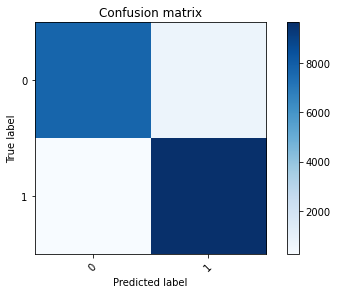

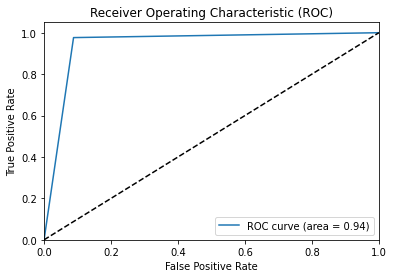

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      8474
           1       0.93      0.98      0.95      9893

    accuracy                           0.95     18367
   macro avg       0.95      0.94      0.95     18367
weighted avg       0.95      0.95      0.95     18367



In [ ]:
# instantiate the model 
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr')

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response
logreg_pred = logreg.predict(x_test)

# Compute the confusion matric
cm = confusion_matrix(y_test, logreg_pred)

# Plot confusion matrics
print(cm)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

# Plot ROC
plot_roc(logreg_pred, y_test)

# Plrint classification report
print(metrics.classification_report(y_test, logreg_pred))

KNN

[[7993  481]
 [ 550 9343]]


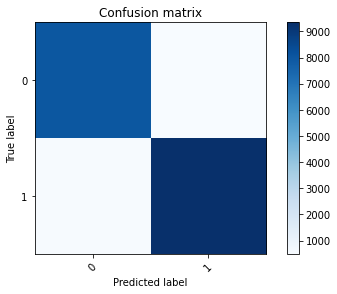

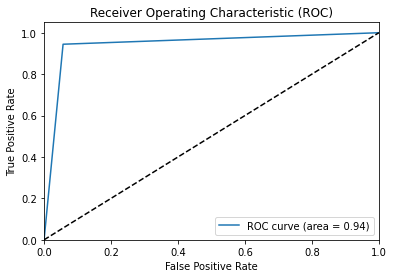

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8474
           1       0.95      0.94      0.95      9893

    accuracy                           0.94     18367
   macro avg       0.94      0.94      0.94     18367
weighted avg       0.94      0.94      0.94     18367



In [ ]:
# instantiate the model (using the value K=1)
knn = KNeighborsClassifier(n_neighbors=1)

# fit the model with data
knn.fit(x_train, y_train)

# predict the response for new observations
knn_pred=knn.predict(x_test)

# Compute the confusion matric
cm = confusion_matrix(y_test, knn_pred)

# Plot confusion matrics
print(cm)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

# Plot ROC
plot_roc(knn_pred, y_test)

# Print classification report
print(metrics.classification_report(y_test, knn_pred))

SVM


[[7857  617]
 [ 146 9747]]


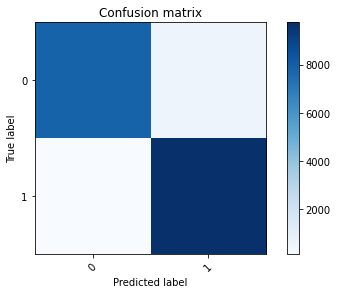

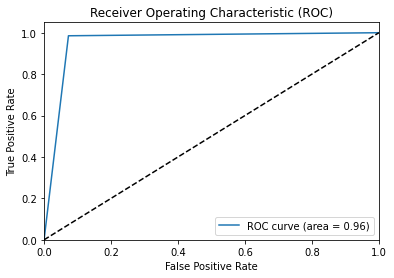

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      8474
           1       0.94      0.99      0.96      9893

    accuracy                           0.96     18367
   macro avg       0.96      0.96      0.96     18367
weighted avg       0.96      0.96      0.96     18367



In [ ]:
svm_clf = SVC(probability=True)
svm_clf.fit(x_train,y_train)
svm_pred=svm_clf.predict(x_test)

# Compute the confusion matric
cm = confusion_matrix(y_test, svm_pred)

# Plot confusion matrics
print(cm)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

# Plot ROC
plot_roc(svm_pred, y_test)

# Print classification report
print(metrics.classification_report(y_test, svm_pred))

Neural Networks

Fit using relu, adam, binary_crossentropy

In [ ]:
#Convert a Pandas dataframe to the x,y
x,y = to_xy(df,"label")
# Split train and test date 70/30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Optimizer:  adam  Activation Function:  relu
Epoch 1/200
1340/1340 - 2s - loss: 0.1243 - val_loss: 0.1012
Epoch 2/200
1340/1340 - 2s - loss: 0.1010 - val_loss: 0.0908
Epoch 3/200
1340/1340 - 2s - loss: 0.0928 - val_loss: 0.0902
Epoch 4/200
1340/1340 - 2s - loss: 0.0904 - val_loss: 0.0842
Epoch 5/200
1340/1340 - 2s - loss: 0.0880 - val_loss: 0.0838
Epoch 6/200
1340/1340 - 2s - loss: 0.0870 - val_loss: 0.0873
Epoch 7/200
1340/1340 - 2s - loss: 0.0857 - val_loss: 0.0841
Epoch 8/200
1340/1340 - 2s - loss: 0.0847 - val_loss: 0.0807
Epoch 9/200
1340/1340 - 2s - loss: 0.0836 - val_loss: 0.0784
Epoch 10/200
1340/1340 - 2s - loss: 0.0823 - val_loss: 0.0822
Epoch 11/200
1340/1340 - 2s - loss: 0.0810 - val_loss: 0.0804
Epoch 12/200
1340/1340 - 2s - loss: 0.0803 - val_loss: 0.0822
Epoch 13/200
1340/1340 - 2s - loss: 0.0792 - val_loss: 0.0788
Epoch 14/200
1340/1340 - 2s - loss: 0.0782 - val_loss: 0.0784
Epoch 00014: early stopping
[[8070  404]
 [ 276 9617]]


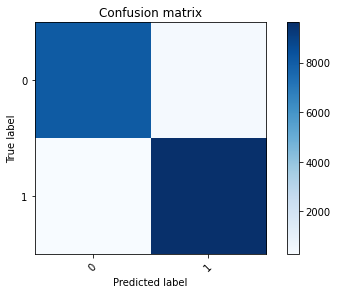

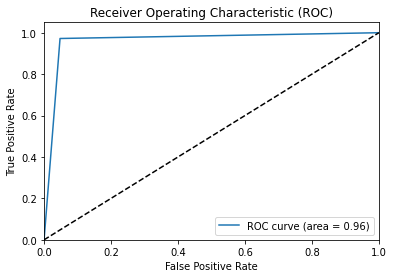

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8474
           1       0.96      0.97      0.97      9893

    accuracy                           0.96     18367
   macro avg       0.96      0.96      0.96     18367
weighted avg       0.96      0.96      0.96     18367




Optimizer:  adam  Activation Function:  sigmoid
Epoch 1/200
1340/1340 - 2s - loss: 0.1721 - val_loss: 0.1151
Epoch 2/200
1340/1340 - 2s - loss: 0.1164 - val_loss: 0.1076
Epoch 3/200
1340/1340 - 2s - loss: 0.1099 - val_loss: 0.1033
Epoch 4/200
1340/1340 - 2s - loss: 0.1049 - val_loss: 0.1047
Epoch 5/200
1340/1340 - 2s - loss: 0.1031 - val_loss: 0.0953
Epoch 6/200
1340/1340 - 2s - loss: 0.1010 - val_loss: 0.0932
Epoch 7/200
1340/1340 - 2s - loss: 0.0991 - val_loss: 0.0919
Epoch 8/200
1340/1340 - 2s - loss: 0.0973 - val_loss: 0.0899
Epoch 9/200
1340/1340 - 2s - loss: 0.0966 - val_loss: 0.0923
Epoch 10/200
1340/1340 - 2s - loss: 0.0951 - val_loss: 0.0889
Epoch 11/20

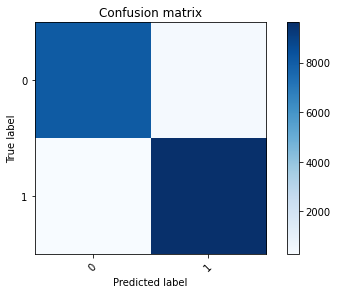

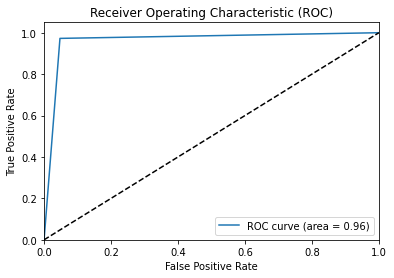

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8474
           1       0.96      0.97      0.97      9893

    accuracy                           0.96     18367
   macro avg       0.96      0.96      0.96     18367
weighted avg       0.96      0.96      0.96     18367




Optimizer:  adam  Activation Function:  tanh
Epoch 1/200
1340/1340 - 2s - loss: 0.1221 - val_loss: 0.0970
Epoch 2/200
1340/1340 - 2s - loss: 0.1001 - val_loss: 0.0917
Epoch 3/200
1340/1340 - 2s - loss: 0.0943 - val_loss: 0.0871
Epoch 4/200
1340/1340 - 2s - loss: 0.0916 - val_loss: 0.0887
Epoch 5/200
1340/1340 - 2s - loss: 0.0899 - val_loss: 0.0870
Epoch 6/200
1340/1340 - 2s - loss: 0.0883 - val_loss: 0.0835
Epoch 7/200
1340/1340 - 2s - loss: 0.0866 - val_loss: 0.0817
Epoch 8/200
1340/1340 - 2s - loss: 0.0854 - val_loss: 0.0813
Epoch 9/200
1340/1340 - 2s - loss: 0.0843 - val_loss: 0.0797
Epoch 10/200
1340/1340 - 2s - loss: 0.0830 - val_loss: 0.0792
Epoch 11/200
1

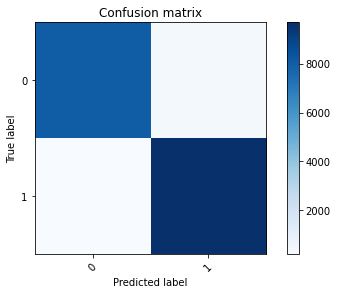

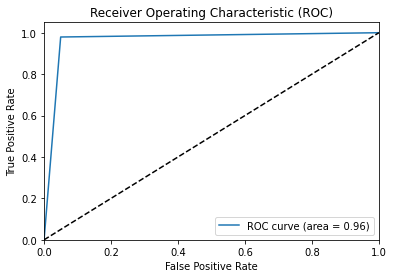

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      8474
           1       0.96      0.98      0.97      9893

    accuracy                           0.97     18367
   macro avg       0.97      0.96      0.97     18367
weighted avg       0.97      0.97      0.97     18367




Optimizer:  sgd  Activation Function:  relu
Epoch 1/200
1340/1340 - 2s - loss: 0.2000 - val_loss: 0.1269
Epoch 2/200
1340/1340 - 1s - loss: 0.1204 - val_loss: 0.1101
Epoch 3/200
1340/1340 - 1s - loss: 0.1105 - val_loss: 0.1017
Epoch 4/200
1340/1340 - 1s - loss: 0.1054 - val_loss: 0.0976
Epoch 5/200
1340/1340 - 1s - loss: 0.1018 - val_loss: 0.0988
Epoch 6/200
1340/1340 - 1s - loss: 0.1007 - val_loss: 0.0943
Epoch 7/200
1340/1340 - 1s - loss: 0.0984 - val_loss: 0.0962
Epoch 8/200
1340/1340 - 1s - loss: 0.0972 - val_loss: 0.0944
Epoch 9/200
1340/1340 - 1s - loss: 0.0961 - val_loss: 0.0905
Epoch 10/200
1340/1340 - 1s - loss: 0.0950 - val_loss: 0.0897
Epoch 11/200
13

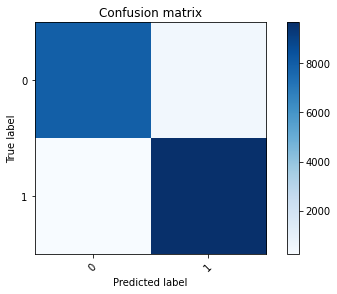

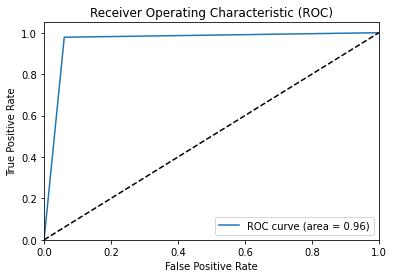

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      8474
           1       0.95      0.98      0.96      9893

    accuracy                           0.96     18367
   macro avg       0.96      0.96      0.96     18367
weighted avg       0.96      0.96      0.96     18367




Optimizer:  sgd  Activation Function:  sigmoid
Epoch 1/200
1340/1340 - 2s - loss: 0.4834 - val_loss: 0.3133
Epoch 2/200
1340/1340 - 1s - loss: 0.2680 - val_loss: 0.2302
Epoch 3/200
1340/1340 - 1s - loss: 0.2152 - val_loss: 0.1923
Epoch 4/200
1340/1340 - 1s - loss: 0.1828 - val_loss: 0.1678
Epoch 5/200
1340/1340 - 1s - loss: 0.1623 - val_loss: 0.1529
Epoch 6/200
1340/1340 - 1s - loss: 0.1504 - val_loss: 0.1448
Epoch 7/200
1340/1340 - 1s - loss: 0.1429 - val_loss: 0.1377
Epoch 8/200
1340/1340 - 1s - loss: 0.1377 - val_loss: 0.1333
Epoch 9/200
1340/1340 - 1s - loss: 0.1336 - val_loss: 0.1303
Epoch 10/200
1340/1340 - 1s - loss: 0.1304 - val_loss: 0.1275
Epoch 11/200

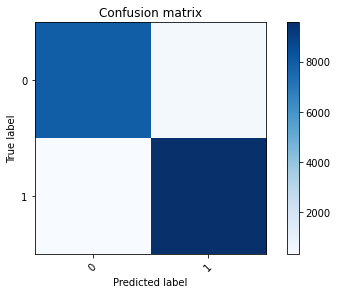

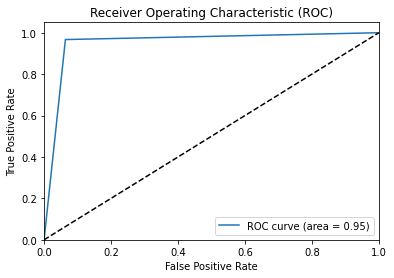

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      8474
           1       0.95      0.97      0.96      9893

    accuracy                           0.95     18367
   macro avg       0.95      0.95      0.95     18367
weighted avg       0.95      0.95      0.95     18367




Optimizer:  sgd  Activation Function:  tanh
Epoch 1/200
1340/1340 - 2s - loss: 0.1810 - val_loss: 0.1279
Epoch 2/200
1340/1340 - 1s - loss: 0.1205 - val_loss: 0.1112
Epoch 3/200
1340/1340 - 1s - loss: 0.1115 - val_loss: 0.1050
Epoch 4/200
1340/1340 - 1s - loss: 0.1075 - val_loss: 0.1045
Epoch 5/200
1340/1340 - 1s - loss: 0.1050 - val_loss: 0.0999
Epoch 6/200
1340/1340 - 1s - loss: 0.1029 - val_loss: 0.0996
Epoch 7/200
1340/1340 - 1s - loss: 0.1018 - val_loss: 0.0977
Epoch 8/200
1340/1340 - 1s - loss: 0.1009 - val_loss: 0.0971
Epoch 9/200
1340/1340 - 1s - loss: 0.1001 - val_loss: 0.0954
Epoch 10/200
1340/1340 - 1s - loss: 0.0994 - val_loss: 0.0978
Epoch 11/200
13

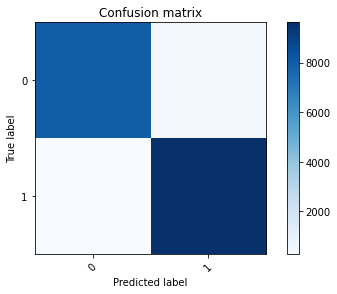

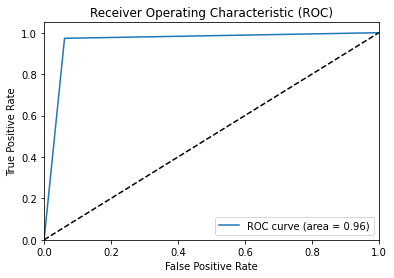

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      8474
           1       0.95      0.97      0.96      9893

    accuracy                           0.96     18367
   macro avg       0.96      0.96      0.96     18367
weighted avg       0.96      0.96      0.96     18367






In [ ]:
# List posible activation functions
activation_functions = ['relu','sigmoid','tanh']
# List posible optimizers
optimizers = ['adam','sgd']

# Loop through all combination of optimizers and activation functions
for optimizer in optimizers:
  for activation_function in activation_functions:
    print("Optimizer: ", optimizer, " Activation Function: ", activation_function)

    model = Sequential()
    model.add(Dense(100, input_dim=x_train.shape[1], activation=activation_function))
    model.add(Dense(50, activation=activation_function))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    #categorical_crossentropy or binary_crossentropy
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    # early stopping
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

    # save best model
    checkpointer = ModelCheckpoint('best_weights.hdf5', verbose=0, save_best_only=True)

    # fit model
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=200)

    # load weights from best model
    model.load_weights('best_weights.hdf5')

    pred_nn = model.predict(x_test)

    nn_predicted = np.argmax(pred_nn, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute the confusion matric
    cm = confusion_matrix(y_true, nn_predicted)

    # Plot confusion matrics
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, [0,1])
    plt.show()

    # Plot ROC
    plot_roc(nn_predicted, y_true)

    # Print classification report
    print(metrics.classification_report(y_true, nn_predicted))

    print("\n\n")